# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random
import warnings

from utils import mape, mean_std_cross_val_scores

from extrucal.extrusion import throughput_cal

warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm

import joblib

random.seed(0)

# 1. Dataset Read In

In [2]:
test_df = pd.read_csv("../data/final_test_df.csv")

In [3]:
# Apply log-transformation to target
test_df["log_throughput"] = np.log1p(test_df["throughput"])

In [4]:
X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

# 2. Evaluation of Performances of Models

In [5]:
before_catb = joblib.load("../models/catb_model.pkl")
after_catb = joblib.load("../models/optimized_catb_model.pkl")

## 2.1. Comparison between Prediction and `y_test`

In [6]:
y_pred_before = np.expm1(before_catb.predict(X_test))
y_pred_after = np.expm1(after_catb.predict(X_test))

In [7]:
y_test = np.expm1(y_test)

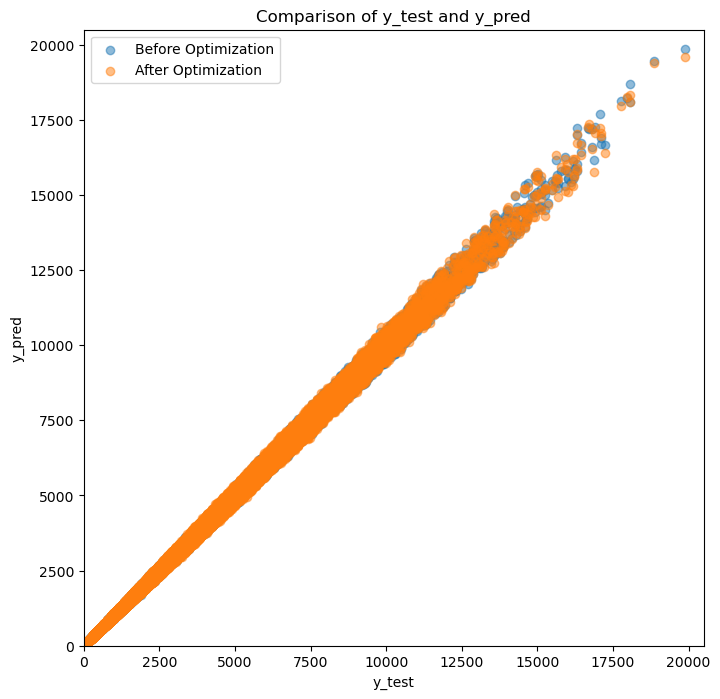

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_before, label="Before Optimization", alpha=0.5)
plt.scatter(y_test, y_pred_after, label="After Optimization", alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.legend()
plt.show();

In [9]:
mape(y_test, y_pred_before)

3.4201387609082543

In [10]:
mape(y_test, y_pred_after)

2.736269003305313

## 2.2. Comparison with `extrucal` results

In [19]:
extruder_size = []
for i in range(25, 251, 25):
    extruder_size.extend([i] * 10)

metering_depth_percent = [0.05] * 100
polymer_density = [1000] * 100
screw_pitch_percent = [1] * 100
flight_width_percent = [0.1] * 100
number_flight = [1] * 100
rpm = [
    r for r in range(0, 92, 10)
] * 10

In [20]:
df = pd.DataFrame(
    {
        "extruder_size": extruder_size,
        "metering_depth_percent": metering_depth_percent,
        "polymer_density": polymer_density,
        "screw_pitch_percent": screw_pitch_percent,
        "flight_width_percent": flight_width_percent,
        "number_flight": number_flight,
        "rpm": rpm,
    }
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size",
    "metering_depth",
    "polymer_density",
    "rpm",
    "screw_pitch",
    "flight_width",
    "number_flight",
]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,25,1.25,1000,0,25,2.5,1
1,25,1.25,1000,10,25,2.5,1
2,25,1.25,1000,20,25,2.5,1
3,25,1.25,1000,30,25,2.5,1
4,25,1.25,1000,40,25,2.5,1


In [21]:
df["CatBoost_before"] = np.expm1(before_catb.predict(df))
df["CatBoost_after"] = np.expm1(after_catb.predict(df))

In [22]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"]),
    ),
    axis=1,
)

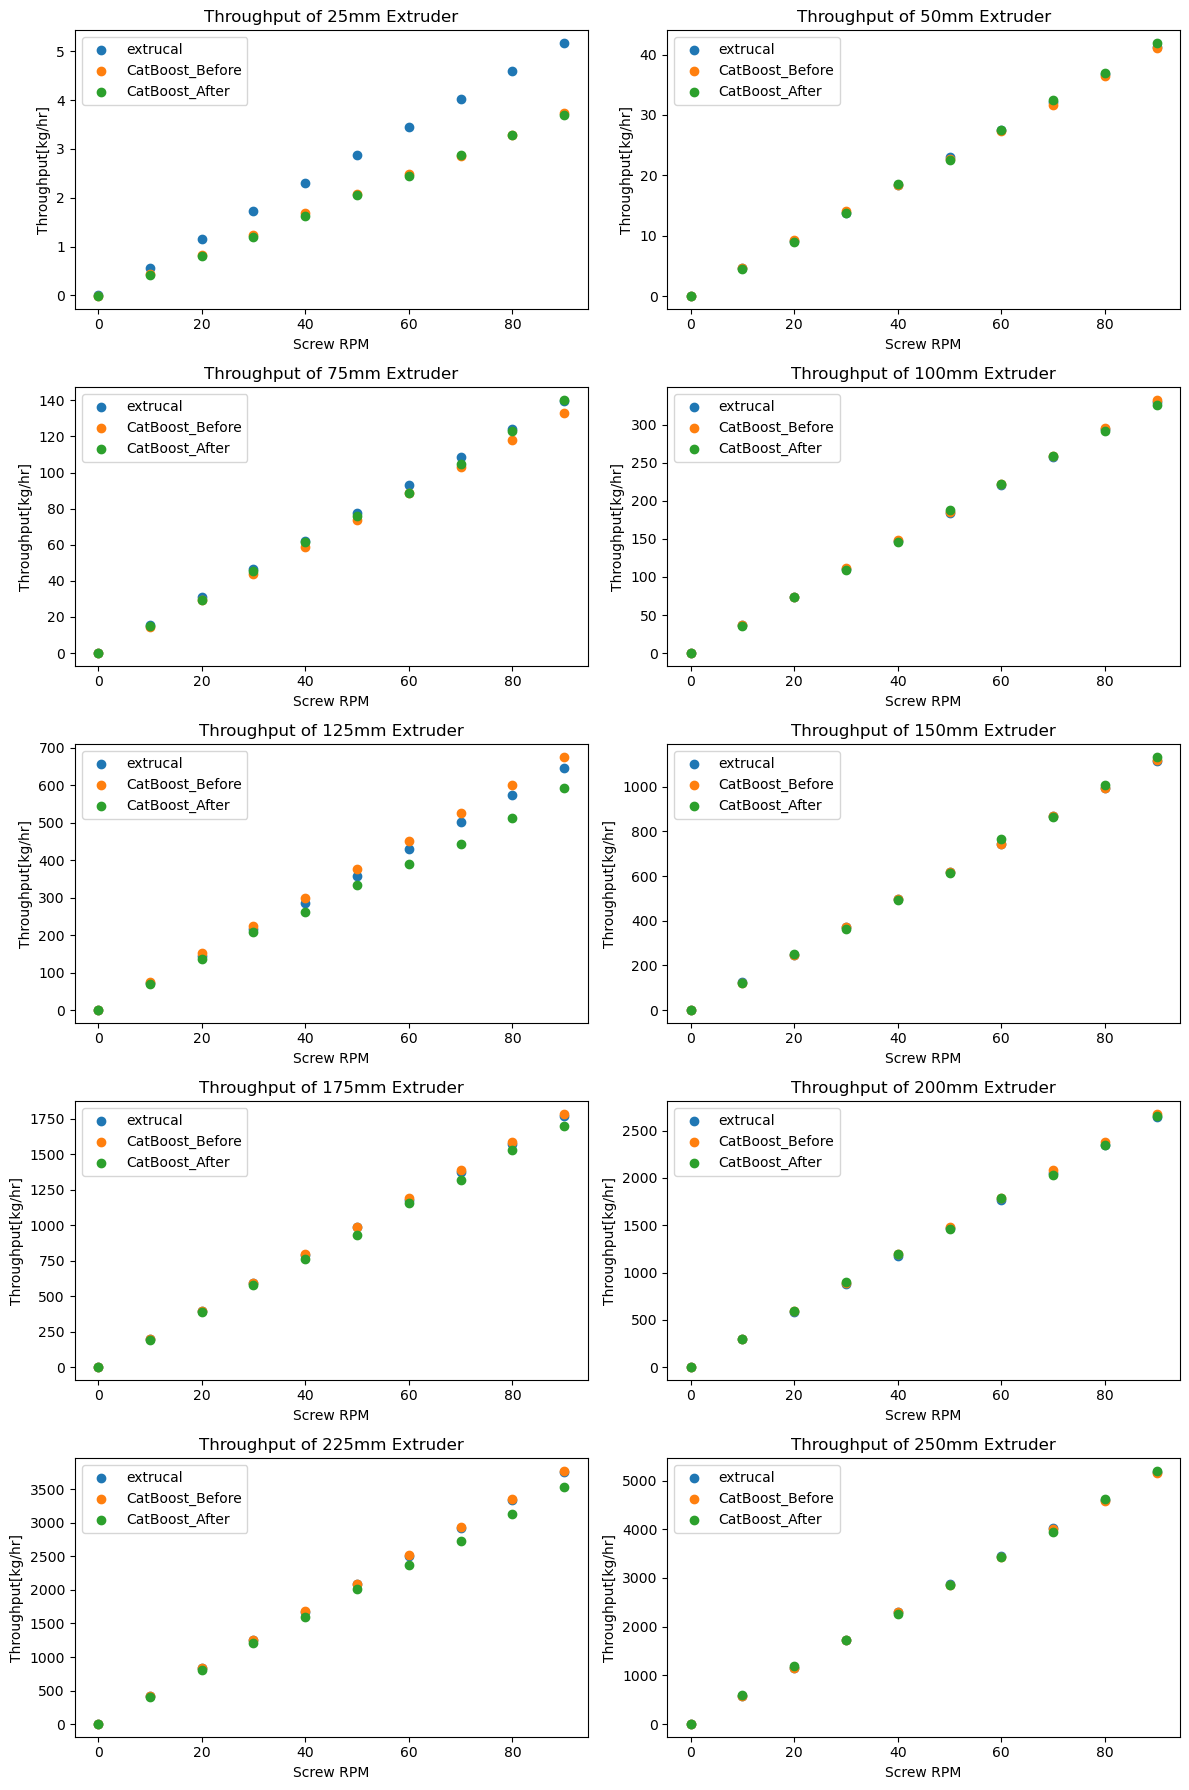

In [23]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=5, ncols=2)
r = 0
c = 0
for size in list(df["extruder_size"].unique()):
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_before"], label="CatBoost_Before")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_after"], label="CatBoost_After")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].set_xlabel("Screw RPM")
    axs[r, c].set_ylabel("Throughput[kg/hr]")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

#### The effect of hyperparameter optimization seems to be insignificant for improving the performance of the model for 25 mm extruder